# Graph analysis and prediction of new edges

*(Author: Aitor Pérez Pérez)*

The goal of this notebook is to reconstruct the graph of co-authorships at EPFL inferred by the provided data files and perform a statistical ML-based analysis. More precisely, we want to predict the future structure of the graph based on its past and present structure.

The notebook is structured as follows:
1. **Preliminaries**
2. **Graph construction**
3. **Preparation before prediction**
4. **Prediction of new edges (without weight nor community)**
5. **Prediction of new edges (with weight and community)**
6. **Model comparison**
7. **Construction of predicted graphs**


## 1. Preliminaries

### Reading data

We read the data files onto variables that we will use for the graph reconstruction.

In [1]:
import json

# Read data files
import numpy as np

with open('data/Person_Lab_Map.json') as f:
    people = json.load(f)

with open('data/Publication_Year.json') as f:
    pubs = json.load(f)

with open('data/Publication_Person_Map.json') as f:
    authorships = json.load(f)

### Data integrity checkup

We start checking the integrity of the data. For that, it will be useful to extract lists from the data we just read.

In [2]:
# Create lists for data integrity validation
lab_ids = [person['LabID'] for person in people]
people_ids = [person['PersonID'] for person in people]

author_ids = [authorship['PersonID'] for authorship in authorships]
authored_pub_ids = [authorship['PublicationID'] for authorship in authorships]

pub_ids = [pub['PublicationID'] for pub in pubs]
years = [pub['Year'] for pub in pubs]

We set variables containing the total number of unique labs, people and publications present in the data.

In [3]:
n_labs = len(set(lab_ids))
n_people = len(set(people_ids))
n_pubs = len(set(pub_ids))

print('Number of unique labs:', n_labs)
print('Number of unique people:', n_people)
print('Number of unique publications:', n_pubs)

Number of unique labs: 441
Number of unique people: 10608
Number of unique publications: 68785


Now we perform some checks. For instance, we make sure every person has one and only one lab in the *Person_Lab_Map* dataset.

In [4]:
assert len(people_ids) == n_people

We also verify that all the people associated with publications in the *Publication_Person_Map* appears in the *Person_Lab_Map* dataset.

In [5]:
assert len(set(author_ids)) == n_people

We make sure that the publications in the *Publication_Year* dataset do not appear twice, possibly with two different years.

In [6]:
assert len(pub_ids) == n_pubs

We check that every publication in the *Publication_Person_Map* dataset is associated with a year in the *Publication_Year* dataset.

In [7]:
assert len(set(authored_pub_ids)) == n_pubs

AssertionError: 

The assumption is not satisfied, let us check what happens. There seems to be one more publication in the *Publication_Person_Map* dataset than in the *Publication_Year* dataset.

In [8]:
len(set(authored_pub_ids))

68786

We find out the ID of the extra publication simply after a set difference operation.

In [9]:
extra_pub_ids = set(authored_pub_ids) - set(pub_ids)
extra_pub_ids

{288914}

Let us now check how far this inconsistency affects the rest of the data. There is only one author for the missing publication.

In [10]:
extra_authorships = [authorship for authorship in authorships if authorship['PublicationID'] in extra_pub_ids]
extra_author_ids = [authorship['PersonID'] for authorship in extra_authorships]
extra_author_ids

[169209]

However, the author seems to have many other valid publications.

In [11]:
len([authorship for authorship in authorships if authorship['PersonID'] in extra_author_ids])

349

And the author seems to be present in the *Person_Lab_Map* dataset.

In [12]:
[person for person in people if person['PersonID'] in extra_author_ids]

[{'PersonID': 169209, 'LabID': 'ECOL'}]

To avoid the inconsistency, we decide to delete the entry corresponding to this publication from the *Publication_Person_Map* data, but leaving its author and the rest of its publications.

In [13]:
authorships = [authorship for authorship in authorships if authorship['PublicationID'] not in extra_pub_ids]

author_ids = [authorship['PersonID'] for authorship in authorships]
authored_pub_ids = [authorship['PublicationID'] for authorship in authorships]

We may now make sure that our assumption holds, i.e. that every publication in the *Publication_Person_Map* dataset is associated with a year in the *Publication_Year* dataset.

In [14]:
assert len(set(authored_pub_ids)) == n_pubs

Finally, we convert the data into pandas DataFrames.

In [15]:
import pandas as pd

people = pd.DataFrame(people)
pubs = pd.DataFrame(pubs)
authorships = pd.DataFrame(authorships)

print('Number of people:', len(people))
print('Number of publications:', len(pubs))
print('Number of authorships:', len(authorships))

Number of people: 10608
Number of publications: 68785
Number of authorships: 145685


## 2. Graph construction

We are now ready to build the graph which will represent the data.

Let *P = [y_min, ..., y_max]* be a period in years (i.e. a list of consecutive integers). We define the graph *G_P* associated with *P* as follows:
* Its node set is the set of people with a publication during *P* with multiple authors.
* There is an edge between two people if they co-authored a publication during *P*.
* Nodes carry the person's lab information in their attributes as the community.
* Edges are weighted. The weight of the edge from u to v is the sum for every year *y* in *P* of *c_y* * *p_y*, where
    * *p_y* is the number of co-authorships by *u* and *v* in the year *y*.
    * *c_y = (1 + (y - y_min)/(y_max - y_min))/2*. This ensures that *c_y* belongs to [1/2, 1] and gives more importance to more recent collaborations, while not ignoring older ones.

In [16]:
def edge_weight(history, ymin, ymax):
    period = range(ymin, ymax + 1)
    cy = [(1 + (y - ymin)/(ymax - ymin))/2 for y in period]
    py = [len(history.get(y, [])) for y in period]

    return sum(a*b for a, b in zip(cy, py))

The following function **build_graph** takes as input the data and a period *P* and constructs and outputs the graph *G_P* as defined above. We do so as follows:
1. Restrict data to the given period *P* by defining the variables **period_pubs** and **period_authorships**.
2. Group authorships by publication. We define a DataFrame **period_coauthorships** with to columns: PublicationID and Coauthorship. For each publication with more than one author, it contains a row with each pair of co-authors.
3. We add the year of publication to **period_coauthorships**.
4. We group by each co-authorship (i.e. each pair of authors). For each pair, we produce a dictionary containing the information of all publications involving both. The resulting DataFrame **coauthorship_history** consists of
    * A **Coauthorship** unique column containing all pairs of co-authors.
    * A **History** column containing a dictionary whose keys are years and whose values are lists of publication IDs, corresponding to the common publications for both authors that year.
5. Restrict people data to the given period *P* by defining the variable **period_people**.
6. Add attributes to nodes and edges and build the graph.

In [17]:
from itertools import combinations
import networkx as nx

def build_graph(people, pubs, authorships, period):
    # 1. Restrict data to period
    period_pubs = pubs.query('Year == @period')
    period_authorships = pd.merge(authorships, period_pubs['PublicationID'], how='inner')
    period_people = pd.merge(people, period_authorships['PersonID'], how='inner').drop_duplicates()

    # 2. Group by publication and generate all pairs of co-authorships.
    period_coauthorships = period_authorships.groupby('PublicationID')['PersonID'].apply(lambda x : list(combinations(sorted(x.values), 2))).apply(pd.Series).stack().reset_index(level=0, name='Coauthorship')

    # 3. Add year information
    period_coauthorships = pd.merge(period_coauthorships, pubs, how='left')

    # 4. Aggregate by co-authorship (i.e. pair of authors)
    def groupby_year(x):
        return x.groupby('Year')['PublicationID'].apply(lambda y: list(y)).to_dict()

    coauthorship_history = period_coauthorships.groupby('Coauthorship')[['PublicationID', 'Year']].apply(groupby_year).reset_index(name='History')

    # 5. Restrict people to period
    period_people_ids = list(set([x for t in coauthorship_history['Coauthorship'].to_list() for x in t]))
    period_people = pd.DataFrame({'PersonID': period_people_ids})
    period_people = pd.merge(period_people, people, how='left')

    # 6. Put together additional information for nodes and edges and build the graph
    nodes = list(period_people['PersonID'])
    node_attrs = list(period_people['LabID'])
    nodes_with_attrs = [(nodes[i], {'community': node_attrs[i]}) for i in range(len(nodes))]

    edges = list(coauthorship_history['Coauthorship'])
    edge_attrs = list(coauthorship_history['History'])
    edges_with_attrs = [edges[i] + ({'weight': edge_weight(edge_attrs[i], min(period), max(period))},) for i in range(len(edges))]

    G = nx.Graph()
    G.add_nodes_from(nodes_with_attrs)
    G.add_edges_from(edges_with_attrs)

    return G

## 3. Preparation before prediction

### Input parameters

Our input parameters are the following:
* **present_year**: Simulated present year. Must be an integer between 2004 and 2021.
* **n_past_years**: Number of additional years in the past for which we consider data. Must be an integer such that 1 <= **n_past_years** <= **present_year** - 2003.
* **n_future_years**: Number of years in the future for which we want to predict new co-authorships. Must be an integer such that 1 <= **future_years**.

In [18]:
present_year = 2011
n_past_years = 3
n_future_years = 2

### Train/validation split

By design choice, **all our models will predict new edges for the graph in the following year**. In order to provide predictions in the subsequent years, we shall iterate the process as many times as needed.

Once the input parameters are defined, and in order to train the models, we need to split the graph into training and validation subsets. A simple way of doing this is simply splitting the graph by year. Our **training set will be the graph corresponding to the period defined by the past years** and the **validation set will be the graph corresponding to the new edges**, i.e. a graph with the same set of nodes and with new edges added in the present year between already present nodes.

In [19]:
train_period = list(range(present_year - n_past_years, present_year))

G_train = build_graph(people, pubs, authorships, train_period)
G_full = build_graph(people, pubs, authorships, train_period + [present_year])

new_edges = G_full.subgraph(G_train).edges - G_train.edges
new_edges = [(min(u, v), max(u, v)) for (u, v) in new_edges]

### Simplification to reduce complexity

We now face a problem with complexity. An ideal approach would be to generate all pairs of nodes which do not share an edge (non-edges), and evaluate for each of them different score measurements in order to decide whether to add that particular edge. This approach, however, does not scale well, since for a graph with *n* nodes and *m* edges, the number of non-edges is *n(n-1) - m*, quadratic in the number of nodes. In our case, we have thousands of vertices and hence milions of non-edges. We need to find a different approach.

In [20]:
n_nodes = len(nx.nodes(G_train))
n_edges = len(nx.edges(G_train))

n_possible_non_edges = n_nodes*(n_nodes-1) - n_edges
n_possible_non_edges

9585710

A possible solution is to **assume that new edges only occur between nodes at a given (small) distance**. In that case, we do not need to generate all non-edges, but only those between such pairs of nodes. For the sake of simplicity, we decide to set this distance to 2. Notice that this limitation does not affect some of the predictive models like the Jaccard coefficient or the Adamic Adar index.

The helper function **step_2_neighbors** takes a graph *G* and a node *u* as parameter and returns a set of the nodes at distance exactly 2 of *u*.

In [21]:
def step_2_neighbors(G, u):
    u_neighbors = set(G.neighbors(u))
    u_2neighbors = set()

    for v in u_neighbors:
        u_2neighbors |= set(G.neighbors(v))

    return u_2neighbors - u_neighbors - set([u])

We now generate the set of non-edges we are considering.

In [22]:
def step_2_non_edges(G):
    non_edges = set()
    for u in G.nodes:
        u_2neighbors = step_2_neighbors(G, u)
        u_non_edges = set((min(u, v), max(u, v)) for v in u_2neighbors)
        non_edges |= u_non_edges
    return non_edges

non_edges = step_2_non_edges(G_train)

We see that we have substantially reduced the total number of non-edges to consider.

In [23]:
len(non_edges)

44836

### Evaluation metrics

We will evaluate the performance of the models in terms of the following metrics: **accuracy, precision, recall, F-score and AUC**.

The following helper function takes the true edges and the predicted edges with score and returns a DataFrame with all these metrics computed for each unique value of score (threshold).

In [24]:
def performance(true_edges, pred_edges):
    # Create DataFrames with the true and predicted edges
    true_edges_df = pd.DataFrame({'Edge': true_edges})
    pred_edges_df = pd.DataFrame({
        'Edge': [(u, v) for (u, v, score) in pred_edges],
        'Coef': [score for (u, v, score) in pred_edges]
    })

    # Merge both DataFrames and extract DataFrames for coincident and non-coincident edges
    all_edges_df = pd.merge(true_edges_df, pred_edges_df, how='outer', indicator=True)
    coincident_edges_df = all_edges_df.query('_merge == "both"')[['Edge', 'Coef']]
    only_true_edges_df = all_edges_df.query('_merge == "left_only"')[['Edge']]
    only_pred_edges_df = all_edges_df.query('_merge == "right_only"')[['Edge', 'Coef']]

    # Thresholds are all possible values of score
    thresholds = sorted(set(score for (u, v, score) in pred_edges) | set([0, 1]))

    # For each threshold, compute confusion matrix and store the values in a DataFrame
    performances = []
    for threshold in thresholds:
        tp = len(coincident_edges_df.query('Coef >= @threshold'))
        fp = len(only_pred_edges_df.query('Coef >= @threshold'))
        fn = len(only_true_edges_df) + len(coincident_edges_df.query('Coef < @threshold'))
        tn = n_possible_non_edges - tp - fp - fn

        performances.append([threshold, tn, fp, fn, tp])
    performances_df = pd.DataFrame(performances, columns=['Threshold', 'TN', 'FP', 'FN', 'TP'])

    # Compute all metrics for each threshold
    performances_df['Accuracy'] = (performances_df['TN'] + performances_df['TP'])/n_possible_non_edges
    performances_df['Precision'] = performances_df['TP']/(performances_df['TP'] + performances_df['FP'])
    performances_df['Recall'] = performances_df['TP']/(performances_df['TP'] + performances_df['FN'])
    performances_df['FScore'] = 2 * performances_df['Precision'] * performances_df['Recall']/(performances_df['Precision'] + performances_df['Recall'])

    performances_df['FPR'] = performances_df['FP']/(performances_df['FP'] + performances_df['TN'])

    return performances_df

The helper function below plots the threshold against the threshold-dependent metrics from the performance DataFrame.

In [25]:
import matplotlib.pyplot as plt

def plot_metrics(performance):
    fig, ax = plt.subplots()
    ax.plot(performance['Threshold'], performance['Accuracy'], label='Accuracy')
    ax.plot(performance['Threshold'], performance['Precision'], label='Precision')
    ax.plot(performance['Threshold'], performance['Recall'], label='Recall')
    ax.plot(performance['Threshold'], performance['FScore'], label='FScore')
    ax.set_xlabel('Threshold')
    ax.set_title('Threshold-dependent metrics')
    ax.legend()

We also define a function to produce a plot of the Receiver Operating Characteristic (ROC) and compute the Area Under Curve (AUC) from the performance DataFrame.

In [26]:
from sklearn.metrics import auc

def plot_roc_auc(performance):
    # Extract FPR and TPR from DataFrame
    fpr = pd.concat([pd.Series([1]), performance['FPR'], pd.Series([0])])
    tpr = pd.concat([pd.Series([1]), performance['Recall'], pd.Series([0])])

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Produce plot
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (AUC = %0.5f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate (1 - Specifity)')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.legend(loc='lower right')

    return roc_auc

## 4. Prediction of new edges (without weight nor community)

We shall now start implementing a variety of statistical models in order to predict new edges in the graph. For now, we will ignore the weight of the edge, so we will treat in the same way a sporadical one-time collaboration and a continuous collaboration over time, and the community of the nodes, so we will not take into account the authors' labs.

### Jaccard coefficient

This is a simple method to predict new edges. Each non-edge is assigned a score, computed as the ratio of the sizes of the intersection and union of their sets of neighbors. The higher this ratio, the more likely the two nodes will be neighbors in the future.

<https://en.wikipedia.org/wiki/Jaccard_index>

In [27]:
j_pred_edges = list(nx.jaccard_coefficient(G_train, non_edges))

j_performance = performance(new_edges, j_pred_edges)
j_performance.head()

,Threshold,TN,FP,FN,TP,Accuracy,Precision,Recall,FScore,FPR
0,0.000000,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.00462
1,0.007812,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.00462
2,0.008065,9540383,44280,492,555,0.995329,0.012379,0.530086,0.024192,0.00462
3,0.008547,9540384,44279,492,555,0.995329,0.012379,0.530086,0.024193,0.00462
4,0.008850,9540385,44278,492,555,0.995330,0.012379,0.530086,0.024194,0.00462


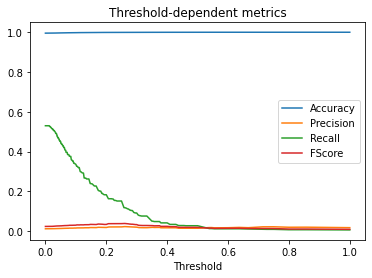

In [28]:
plot_metrics(j_performance)

0.7629881635116776

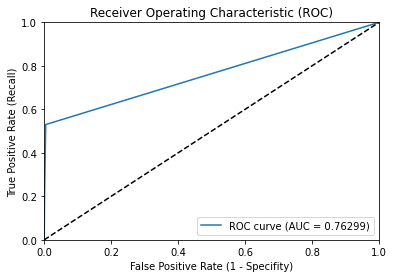

In [29]:
plot_roc_auc(j_performance)

### Adamic-Adar index

Another simple method to predict new edges. Each non-edge (u,v) is again assigned a score, this time computed as the sum of the inverse logarithmic degree centrality of the neighbours shared by u and v, and the inverse logarithmic degree centrality of a node w is the inverse of the logarithm of the number of neighbors of w. Again, the higher this index, the more likely a non-edge is missing. We however normalize the index by dividing by the maximum value so that all values are in [0, 1], and can be interpreted as rough probabilities.

<https://en.wikipedia.org/wiki/Adamic/Adar_index>

In [30]:
aa_pred_edges = list(nx.adamic_adar_index(G_train, non_edges))

# Normalization
aa_max_score = max([score for u, v, score in aa_pred_edges])
aa_pred_edges = [(u, v, score/aa_max_score) for u, v, score in aa_pred_edges]

aa_performance = performance(new_edges, aa_pred_edges)
aa_performance.head()

,Threshold,TN,FP,FN,TP,Accuracy,Precision,Recall,FScore,FPR
0,0.000000,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.004620
1,0.031341,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.004620
2,0.032655,9541596,43067,494,553,0.995456,0.012678,0.528176,0.024761,0.004493
3,0.033228,9543681,40982,495,552,0.995673,0.013290,0.527221,0.025927,0.004276
4,0.033380,9545045,39618,522,525,0.995813,0.013078,0.501433,0.025492,0.004133


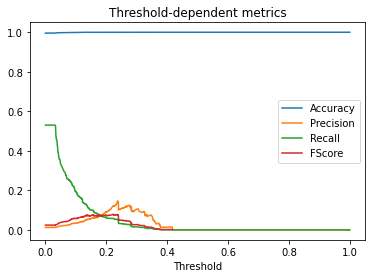

In [31]:
plot_metrics(aa_performance)

0.7631452514208182

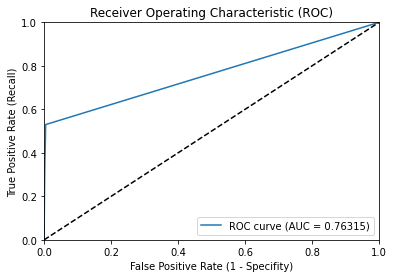

In [32]:
plot_roc_auc(aa_performance)

### Preferential attachment

The preferential attachment method assigns once more a score to a pair of nodes. In this case, this score is the product of the number of neighbors of u and v. This emulates the behavior of nodes with many connections relating among themselves. We again normalize the score to interpret it as a rough probability in [0, 1].

In [33]:
pa_pred_edges = list(nx.preferential_attachment(G_train, non_edges))

# Normalization
pa_max_score = max([score for u, v, score in pa_pred_edges])
pa_pred_edges = [(u, v, score/pa_max_score) for u, v, score in pa_pred_edges]

pa_performance = performance(new_edges, pa_pred_edges)
pa_performance.head()

,Threshold,TN,FP,FN,TP,Accuracy,Precision,Recall,FScore,FPR
0,0.000000,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.004620
1,0.000242,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.004620
2,0.000484,9540651,44012,496,551,0.995357,0.012365,0.526266,0.024161,0.004592
3,0.000726,9541411,43252,506,541,0.995435,0.012354,0.516714,0.024130,0.004513
4,0.000969,9542072,42591,515,532,0.995503,0.012337,0.508118,0.024089,0.004444


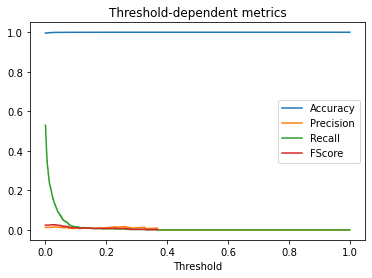

In [34]:
plot_metrics(pa_performance)

0.7627589444868653

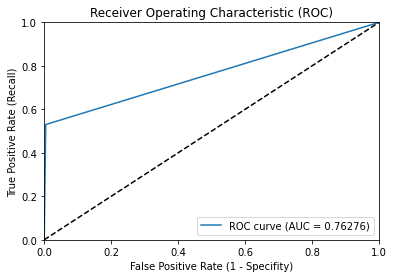

In [35]:
plot_roc_auc(pa_performance)

## 5. Prediction of new edges (with weight and community)

We now want to include the **edge weight** information as well as the **node community** into the models. To do so, we will **modify the models that we have already used** to take this information into account, yielding **custom extensions that work with node-labeled, edge-weighted graphs**. In all cases, these extended models are equivalent to the base ones when used on graphs all whose edges have weight 1 and all nodes different community.

### Weighted Jaccard coefficient

We want to extend the Jaccard coefficient to graphs with edge weights and node labels. The solution we propose is to do the following replacements in the Jaccard coefficient formula for two nodes *u* and *v*:
* Replace the size of the intersection by the sum over all nodes *w* in the intersection of the average of the weights of the edges *(u, w)* and *(v, w)*.
* Replace the size of the union by the expression above plus the sum over all nodes *w* connected to only one of *u*, *v* of the corresponding edge weight.
* Add a multiplicative factor so the contribution of a common neighbor *w* is doubled if its community coincides with that of *u* or *v*.

The precise definition we propose for the weighted Jaccard coefficient between *u* and *v* is given by:

<br />
<img width=700 src="img/weighted-jaccard.png">

where *a_{(w, w')}* is the weight of the edge between *w* and *w'*, and *f(w)* equals 1 if the community of *w* coincides with that of *u* or *v*, 0 otherwise.

We provide an implementation of the function **weighted_jaccard_coefficient** which mimics that of the regular jaccard_coefficient in the package *networkx*. In particular, it has the parameters:
* G: graph.
    * A NetworkX undirected graph.
* ebunch: iterable of node pairs, optional (default = None)
    * The weighted Jaccard coefficient will be computed for each pair of nodes given in the iterable. The pairs must be given as 2-tuples (u, v) where u and v are nodes in the graph. If ebunch is None then all non-existent edges in the graph will be used. Default value: None.
* community: string, optional (default = 'community')
    * Nodes attribute name containing the community information. G[u][community] identifies which community u belongs to. Each node belongs to at most one community. Default value: 'community'.
* weight: string, optional (default = 'weight')
    * Edges attribute name containing the weight information. G[u][v][weight] identifies the weight of the edge between u and v. Each edge has a weight. Default value: 'weight'.

And returns:
* piter : iterator
    * An iterator of 3-tuples in the form (u, v, p) where (u, v) is a pair of nodes and p is their score.


In [36]:
from networkx.algorithms.link_prediction import _apply_prediction

def weighted_jaccard_coefficient(G, ebunch=None, community='community', weight='weight'):
    def predict(u, v):
        union = set(G[u]) | set(G[v])
        intersection = set(G[u]) & set(G[v])

        union_weight = sum([(G[u][w][weight] + G[v][w][weight])/2 for w in intersection])
        for w in union - intersection:
            union_weight += G[u][w][weight] if G.has_edge(u, w) else 0
            union_weight += G[v][w][weight] if G.has_edge(v, w) else 0

        if not union or union_weight == 0:
            return 0

        def f(w):
            if G.nodes[u][community] == G.nodes[w][community] or G.nodes[v][community] == G.nodes[w][community]:
                return 1
            return 0

        intersection_weight = sum([(1 + f(w))*(G[u][w][weight] + G[v][w][weight])/2 for w in intersection])

        return intersection_weight / union_weight

    return _apply_prediction(G, predict, ebunch)

In [37]:
wj_pred_edges = list(weighted_jaccard_coefficient(G_train, non_edges))

# Normalization
wj_max_score = max([score for u, v, score in wj_pred_edges])
wj_pred_edges = [(u, v, score/wj_max_score) for u, v, score in wj_pred_edges]

wj_performance = performance(new_edges, wj_pred_edges)
wj_performance.head()

,Threshold,TN,FP,FN,TP,Accuracy,Precision,Recall,FScore,FPR
0,0.000000,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.00462
1,0.000806,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.00462
2,0.000831,9540383,44280,492,555,0.995329,0.012379,0.530086,0.024192,0.00462
3,0.000836,9540384,44279,492,555,0.995329,0.012379,0.530086,0.024193,0.00462
4,0.000865,9540385,44278,492,555,0.995330,0.012379,0.530086,0.024194,0.00462


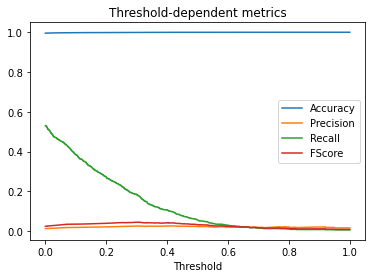

In [38]:
plot_metrics(wj_performance)

0.763117603033228

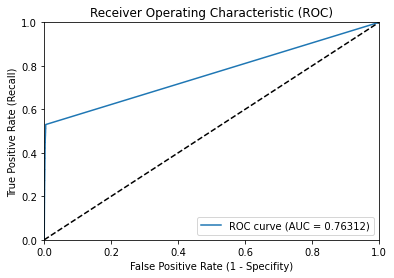

In [39]:
plot_roc_auc(wj_performance)

### Weighted Adamic-Adar index

We now want to do the same for the Adamic-Adar index. The solution we propose is to replace in the original formula the number of neighbors of a node *w* by the sum of the weights of its edges. In addition, we too add the multiplicative factor to double the contribution of a common neighbor in case it shares its community with *u* or *v*.

The precise definition we propose for the weighted Adamic-Adar index between *u* and *v* is given by:

<br />
<img width=400 src="img/weighted-adamic-adar.png">

where *a_{(w, w')}* is the weight of the edge between *w* and *w'*, and *f(w)* equals 1 if the community of *w* coincides with that of *u* or *v*, 0 otherwise.

Again we provide an implementation of the function **weighted_adamic_adar_index** which mimics that of the regular adamic_adar_index in the package *networkx*. Its parameters are:
* G: graph.
    * A NetworkX undirected graph.
* ebunch: iterable of node pairs, optional (default = None)
    * The weighted Adamic-Adar index will be computed for each pair of nodes given in the iterable. The pairs must be given as 2-tuples (u, v) where u and v are nodes in the graph. If ebunch is None then all non-existent edges in the graph will be used. Default value: None.
* community: string, optional (default = 'community')
    * Nodes attribute name containing the community information. G[u][community] identifies which community u belongs to. Each node belongs to at most one community. Default value: 'community'.
* weight: string, optional (default = 'weight')
    * Edges attribute name containing the weight information. G[u][v][weight] identifies the weight of the edge between u and v. Each edge has a weight. Default value: 'weight'.

And returns:
* piter : iterator
    * An iterator of 3-tuples in the form (u, v, p) where (u, v) is a pair of nodes and p is their index.

In [40]:
from math import log

def weighted_adamic_adar_index(G, ebunch=None, community='community', weight='weight'):
    def predict(u, v):
        def f(w):
            if G.nodes[u][community] == G.nodes[w][community] or G.nodes[v][community] == G.nodes[w][community]:
                return 1
            return 0

        return sum([(1 + f(w)) / (log(1 + sum([G[w][z][weight] for z in set(G[w])]))) for w in nx.common_neighbors(G, u, v)])

    return _apply_prediction(G, predict, ebunch)

In [41]:
waa_pred_edges = list(weighted_adamic_adar_index(G_train, non_edges))

# Normalization
waa_max_score = max([score for u, v, score in waa_pred_edges])
waa_pred_edges = [(u, v, score/waa_max_score) for u, v, score in waa_pred_edges]

waa_performance = performance(new_edges, waa_pred_edges)
waa_performance.head()

,Threshold,TN,FP,FN,TP,Accuracy,Precision,Recall,FScore,FPR
0,0.000000,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.004620
1,0.022808,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.004620
2,0.023058,9540418,44245,492,555,0.995333,0.012388,0.530086,0.024211,0.004616
3,0.023113,9540490,44173,492,555,0.995340,0.012408,0.530086,0.024249,0.004609
4,0.023156,9540496,44167,492,555,0.995341,0.012410,0.530086,0.024252,0.004608


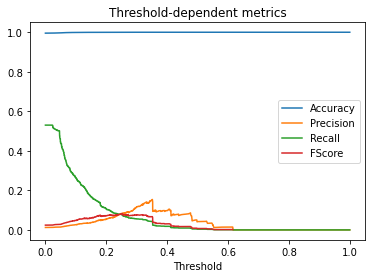

In [42]:
plot_metrics(waa_performance)

0.7631681258850082

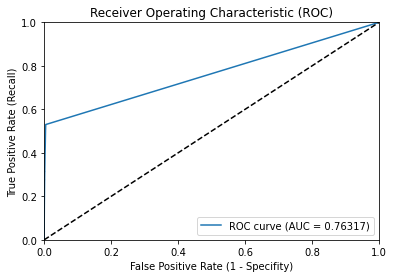

In [43]:
plot_roc_auc(waa_performance)

### Weighted Preferential Attachment

We now do the same with Preferential attachment. In this case, we replace again the number of neighbors of a node *w* by the sum of the weights of its edges, and use the community information to double the contribution of neighbors within the same community.

The precise definition we propose for the weighted Preferential Attachment between *u* and *v* is given by:

<br />
<img width=600 src="img/weighted-preferential-attachment.png">

where *a_{(w, w')}* is the weight of the edge between *w* and *w'*, and *f(w, w')* equals 1 if the community of *w* coincides with that of *w'*, 0 otherwise.

Once more we provide an implementation of the function **weighted_preferential_attachment** which mimics that of the regular preferential_attachment in the package *networkx*. Its parameters are:
* G: graph.
    * A NetworkX undirected graph.
* ebunch: iterable of node pairs, optional (default = None)
    * The weighted preferential attachment score will be computed for each pair of nodes given in the iterable. The pairs must be given as 2-tuples (u, v) where u and v are nodes in the graph. If ebunch is None then all non-existent edges in the graph will be used. Default value: None.
* community: string, optional (default = 'community')
    * Nodes attribute name containing the community information. G[u][community] identifies which community u belongs to. Each node belongs to at most one community. Default value: 'community'.
* weight: string, optional (default = 'weight')
    * Edges attribute name containing the weight information. G[u][v][weight] identifies the weight of the edge between u and v. Each edge has a weight. Default value: 'weight'.

And returns:
* piter : iterator
    * An iterator of 3-tuples in the form (u, v, p) where (u, v) is a pair of nodes and p is their score.

In [44]:
def weighted_preferential_attachment(G, ebunch=None, community='community', weight='weight'):
    def predict(u, v):
        def f(w1, w2):
            if G.nodes[w1][community] == G.nodes[w2][community]:
                return 1
            return 0

        return sum([(1 + f(u, w)) * G[u][w][weight] for w in set(G[u])]) * sum([(1 + f(v, w)) * G[v][w][weight] for w in set(G[v])])

    return _apply_prediction(G, predict, ebunch)

In [45]:
wpa_pred_edges = list(weighted_preferential_attachment(G_train, non_edges))

# Normalization
wpa_max_score = max([score for u, v, score in wpa_pred_edges])
wpa_pred_edges = [(u, v, score/wpa_max_score) for u, v, score in wpa_pred_edges]

wpa_performance = performance(new_edges, wpa_pred_edges)
wpa_performance.head()

,Threshold,TN,FP,FN,TP,Accuracy,Precision,Recall,FScore,FPR
0,0.000000,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.00462
1,0.000001,9540382,44281,492,555,0.995329,0.012378,0.530086,0.024192,0.00462
2,0.000002,9540383,44280,492,555,0.995329,0.012379,0.530086,0.024192,0.00462
3,0.000002,9540384,44279,492,555,0.995329,0.012379,0.530086,0.024193,0.00462
4,0.000003,9540386,44277,492,555,0.995330,0.012380,0.530086,0.024194,0.00462


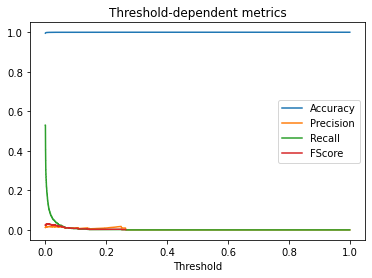

In [46]:
plot_metrics(wpa_performance)

0.7628561857600177

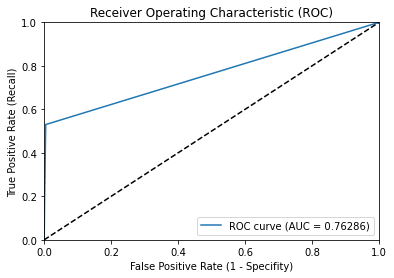

In [47]:
plot_roc_auc(wpa_performance)

## 6. Model comparison

Let us now compare all models among themselves. We start by defining a helper function to plot a metric across all models.

In [48]:
def cross_plot(performances, field, colors, linestyles):
    fig, ax = plt.subplots()
    for model in performances:
        ax.plot(performances[model]['Threshold'], performances[model][field], label=model, color=colors[model], linestyle=linestyles[model], alpha=0.8)
    ax.set_xlabel('Threshold')
    ax.set_title(field)
    ax.legend()

We aggregate all performance data in a single variable, and create style variables for the plots.

In [49]:
performances = {
    'J': j_performance,
    'AA': aa_performance,
    'PA': pa_performance,
    'WJ': wj_performance,
    'WAA': waa_performance,
    'WPA': wpa_performance
}

colors = {
    'J': 'tab:blue',
    'AA': 'tab:orange',
    'PA': 'tab:green',
    'WJ': 'tab:blue',
    'WAA': 'tab:orange',
    'WPA': 'tab:green'
}

linestyles = {
    'J': 'dashed',
    'AA': 'dashed',
    'PA': 'dashed',
    'WJ': 'solid',
    'WAA': 'solid',
    'WPA': 'solid'
}

And we cross plot all metrics to compare the models.

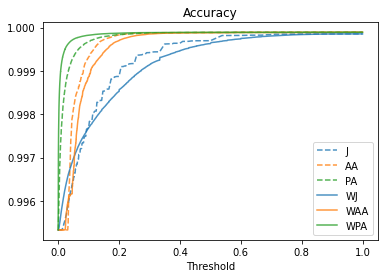

In [50]:
cross_plot(performances, 'Accuracy', colors, linestyles)

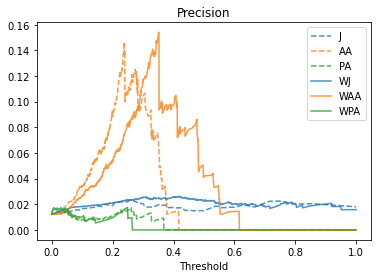

In [51]:
cross_plot(performances, 'Precision', colors, linestyles)

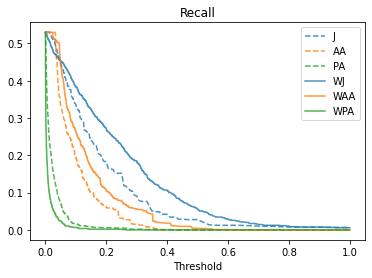

In [52]:
cross_plot(performances, 'Recall', colors, linestyles)

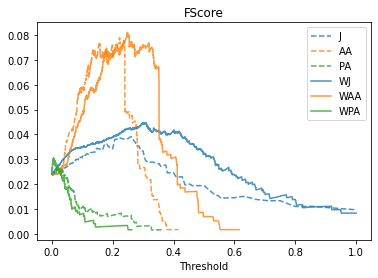

In [53]:
cross_plot(performances, 'FScore', colors, linestyles)

We also compare the ROC and the AUC for each model.

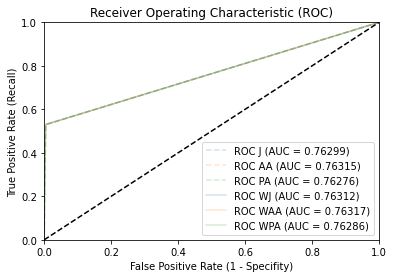

In [54]:
fig, ax = plt.subplots()

for model in performances:
    # Extract FPR and TPR from DataFrame
    fpr = pd.concat([pd.Series([1]), performances[model]['FPR'], pd.Series([0])])
    tpr = pd.concat([pd.Series([1]), performances[model]['Recall'], pd.Series([0])])
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    # Plot curve
    ax.plot(fpr, tpr, label='ROC ' + model + ' (AUC = %0.5f)' % roc_auc, color=colors[model], linestyle=linestyles[model], alpha=0.2)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False Positive Rate (1 - Specifity)')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('Receiver Operating Characteristic (ROC)')
ax.legend(loc='lower right')

### Conclusion

After comparing the different metrics across all models, we may extract several conclusions:
* The problem itself is hard. It is not easy even for human intuition to guess the future scientific collaborations, as there are no clear rules under which coauthorships happen in real life.
* There is not much difference among the models we propose. However, the weighted versions of Jaccard coefficient and Adamic-Adar seem to marginally improve the regular ones, especially the former, and have slightly greater AUC.
* Accuracy is very close to 1. This is because the number of true negatives is very high, the vast majority of non-edges are correctly predicted.
* For low thresholds, the recall is rather high. The lower the threshold, the more edges we add, and hence the more of the actual new edges we predict correctly.
* Precision is never very high. Since there are many possible new edges, the ones we predict are not very often the true ones. This also makes the F-score low.
* For the ROC and AUC, we get very similar results. Again this is due to the large number of correctly predicted non-edges. For this metric, however, there is clearly a benefit of using any of the models against a random prediction of edges.

## 7. Construction of predicted graphs

We may now finish by constructing the predicted graph taking the input parameters into account. For simplicity, we shall use the weighted Adamic-Adar index, but we could use any combination of the models above. As probability threshold to decide which edges to include, we shall use the one maximizing the F-score. For each added edge, its weight will be the floor of its score divided by the threshold.

In [55]:
import math

future_period = list(range(present_year + 1, present_year + n_future_years + 1))
G = G_train.copy()

performances = {}
predicted_graphs = {}
for future_year in future_period:
    # Build new edges for validation
    full_period = list(range(present_year - n_past_years, future_year))
    G_full = build_graph(people, pubs, authorships, full_period)

    new_edges = G_full.subgraph(G).edges - G.edges
    new_edges = [(min(u, v), max(u, v)) for (u, v) in new_edges]

    # Compute number of possible non-edges
    n_nodes = len(nx.nodes(G))
    n_edges = len(nx.edges(G))
    n_possible_non_edges = n_nodes*(n_nodes-1) - n_edges

    # Compute 2-step non-edges
    non_edges = step_2_non_edges(G)

    # Edge prediction
    pred_edges = list(weighted_adamic_adar_index(G, non_edges))
    max_score = max([score for u, v, score in pred_edges])
    pred_edges = [(u, v, score/max_score) for u, v, score in pred_edges]

    # Compute performance, select best threshold and make final prediction
    performances[future_year] = performance(new_edges, pred_edges)
    max_fscore_idx = performances[future_year]['FScore'].idxmax()
    threshold = performances[future_year]['Threshold'][max_fscore_idx]

    pred_edges = [(u, v, math.floor(score/threshold)) for u, v, score in pred_edges if score >= threshold]

    # Build and save next graph
    G.add_weighted_edges_from(pred_edges)
    predicted_graphs[future_year] = G.copy()

We finish by writing all graphs into json files.

In [56]:
from networkx.readwrite import json_graph

# Need to convert numpy.int64 to int
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        else:
            return super(MyEncoder, self).default(obj)

def write_graph(G, filename):
    G_json = json_graph.node_link_data(G)

    with open(filename, 'w') as f:
        json.dump(G_json, f, cls=MyEncoder)

In [57]:
write_graph(G_train, 'out/present.json')
for future_year in future_period:
    write_graph(predicted_graphs[future_year], f'out/future-{future_year - present_year}.json')